In [1]:
%cd "C:\Users\braya\Documents\github\SeismicEnhancement"

C:\Users\braya\Documents\github\SeismicEnhancement


In [2]:
import os 
import torch 

from dataclasses import dataclass
from torchvision.utils import make_grid


from libs.difussion.utils import get_default_device
from libs.difussion.dataloader import get_dataloader, inverse_transform


from libs.difussion.config import BaseConfig, TrainingConfig, ModelConfig

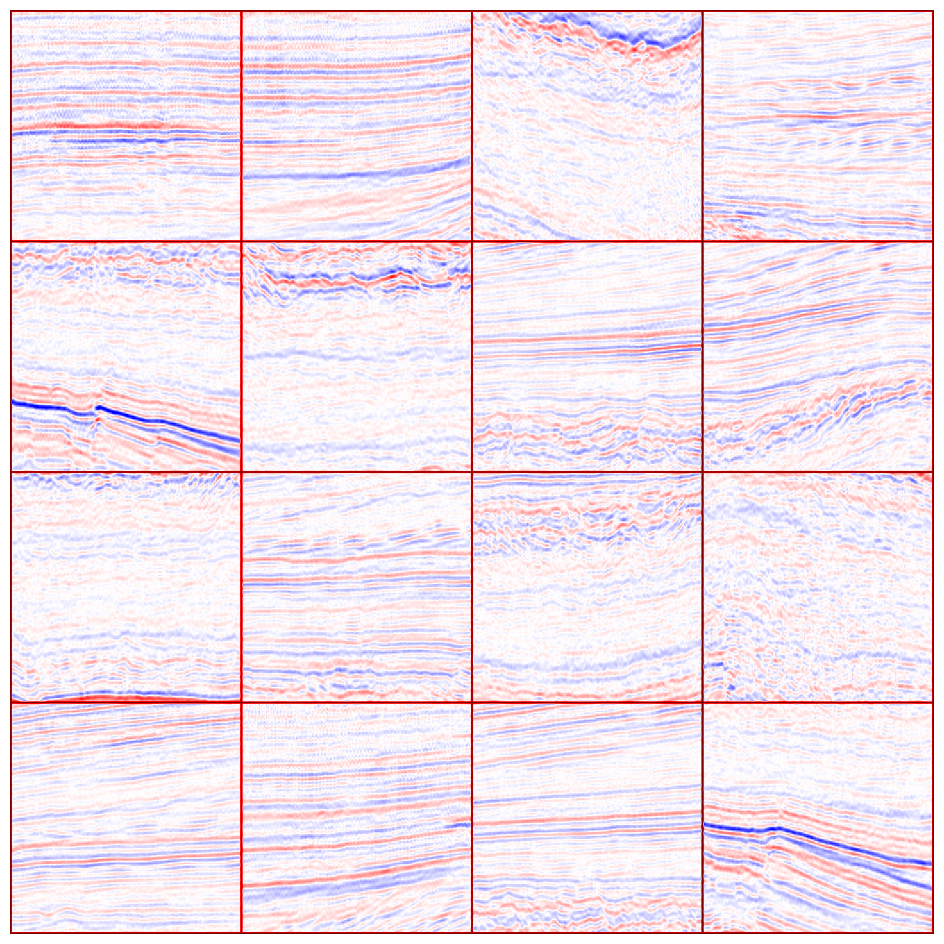

In [3]:
import matplotlib.pyplot as plt

loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=16,
    device='cpu',
)

plt.figure(figsize=(12, 12), facecolor='white')

for sample in loader:
    b_image, b_label = sample
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=4, padding=True, pad_value=1, normalize=False)
    plt.imshow(grid_img.permute(1, 2, 0)[..., 0], cmap="seismic", vmin=0, vmax=1)
    plt.axis("off")
    break

In [4]:
from libs.difussion.ddpm import SimpleDiffusion, forward_diffusion

sd = SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device="cpu")

loader = iter(  # converting dataloader into an iterator for now.
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=4,
        device="cpu",
    )
)

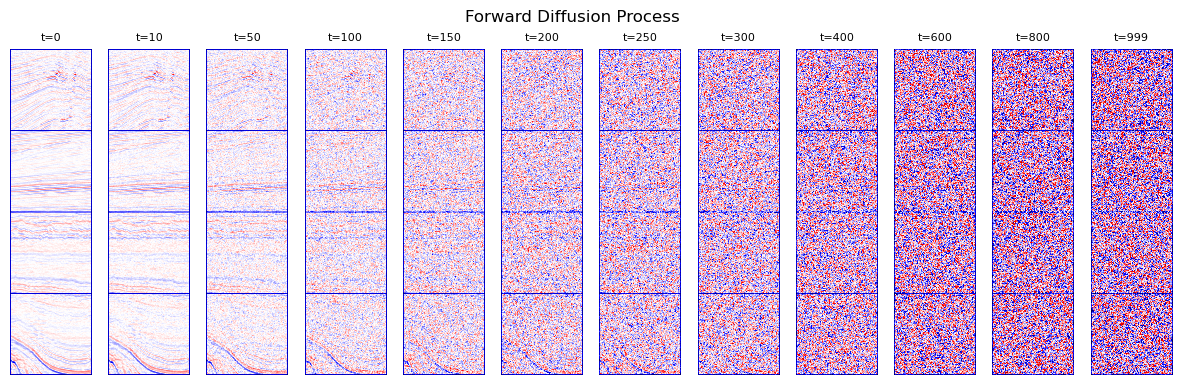

In [5]:
x0s, _ = next(loader)

noisy_images = []
# specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts    = inverse_transform(xts) / 255.0
    xts    = make_grid(xts, nrow=1, padding=1)
    
    noisy_images.append(xts)

# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(15, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0)[..., 0], cmap="seismic", vmin=0, vmax=1)
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

In [6]:
import torch.nn as nn
from libs.difussion.models import ContextUNet

from torch.cuda import amp

model = ContextUNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
model.to(BaseConfig.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    # pin_memory    = False,
    # num_workers   = TrainingConfig.NUM_WORKERS,
)

loss_fn = nn.MSELoss()

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

scaler = amp.GradScaler()

In [7]:
from libs.difussion.utils import setup_log_directory

total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())

# log_dir = r"Logs_Checkpoints\Inference\version_9"
# checkpoint_dir = r"Logs_Checkpoints\checkpoints\version_9"

generate_video = False
ext = ".mp4" if generate_video else ".png"

Logging at: Logs_Checkpoints\Inference\version_10
Model Checkpoint at: Logs_Checkpoints\checkpoints\version_10


In [9]:
# checkpoint_path = os.path.join(checkpoint_dir, "ckpt.tar")
# model.load_state_dict(torch.load(checkpoint_path, map_location='cpu')['model'])

Train :: Epoch: 1/10000:   0%|          | 0/197 [00:00<?, ?it/s]

Sampling :: 100%|██████████| 999/999 [00:37<00:00, 26.48it/s]


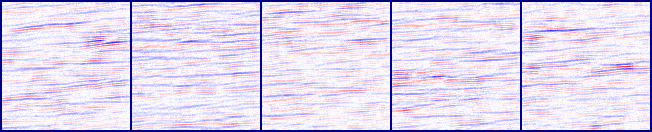

Sampling :: 100%|██████████| 999/999 [00:37<00:00, 26.69it/s]


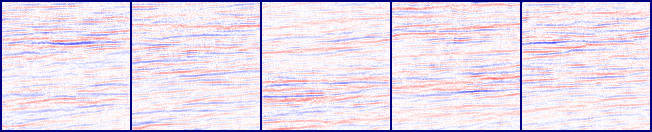

Sampling :: 100%|██████████| 999/999 [00:35<00:00, 27.78it/s]


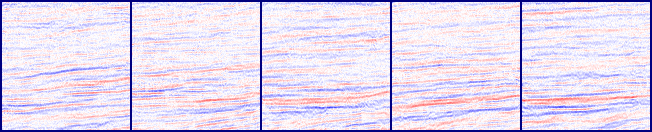

Sampling :: 100%|██████████| 999/999 [00:35<00:00, 27.82it/s]


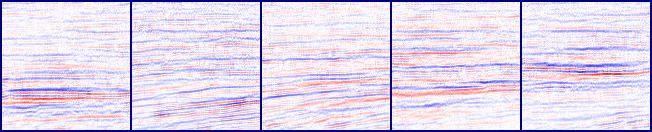

Sampling :: 100%|██████████| 999/999 [00:35<00:00, 27.92it/s]


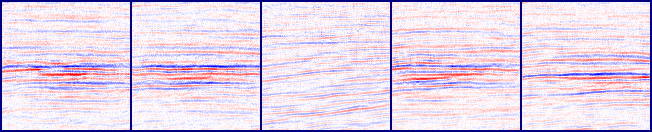

Sampling ::  85%|████████▍ | 848/999 [00:31<00:05, 26.57it/s]


KeyboardInterrupt: 

In [10]:
import gc 

from libs.difussion.train import train_one_epoch, cond_reverse_diffusion

for epoch in range(1, total_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch, condition=True)

    if epoch % 5 == 0:
        save_path = os.path.join(log_dir, f"{epoch}{ext}")
        
        # Algorithm 2: Sampling
        cond_reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, num_images=5, generate_video=generate_video,
            save_path=save_path, img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE,
        )

        # clear_output()
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar"))
        del checkpoint_dict